In [1]:
import numpy as np
import pandas as pd
from epiweeks import Week
import matplotlib.pyplot as plt
from mosqlient import get_predictions
from mosqlient.models.score import Scorer

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('data/dengue.csv.gz')

data.head()

,date,year,epiweek,casos,geocode,regional,regional_geocode,macroregional,macroregional_geocode,uf,train_1,train_2,target_1,target_2
0,2010-01-03,2010,201001,0,4208450,Nordeste,42011,Planalto Norte e Nordeste,4211,SC,True,True,False,False
1,2010-01-03,2010,201001,0,4216206,Nordeste,42011,Planalto Norte e Nordeste,4211,SC,True,True,False,False
2,2010-01-03,2010,201001,0,4218509,Meio Oeste,42008,Meio Oeste e Serra Catarinense,4212,SC,True,True,False,False
3,2010-01-03,2010,201001,0,4216404,Extremo Sul Catarinense,42014,Sul,4210,SC,True,True,False,False
4,2010-01-03,2010,201001,0,4201307,Nordeste,42011,Planalto Norte e Nordeste,4211,SC,True,True,False,False


In [4]:
def get_cases(data, state):
    data_ = data.loc[data.uf == state]
    
    data_.loc[:, 'date']  = pd.to_datetime(data_.date)
    
    data_.set_index('date', inplace = True)
    
    data_ = data_[['casos']].resample('W-SUN').sum()

    data_ = data_.reset_index()

    data_ = data_.rename(columns = {'date':'dates'})
    
    return data_

Defining the data around the peak:

In [5]:
data_23 = data.loc[data.target_1 == True]
data_24 = data.loc[data.target_2 == True]

In [6]:
peak_dates = {'AM':{2023: {}, 2024: {}}, 'CE': {2023: {}, 2024: {}}, 'GO':{2023: {}, 2024: {}}, 'PR':{2023: {}, 2024: {}}, 'MG':{2023: {}, 2024: {}}}

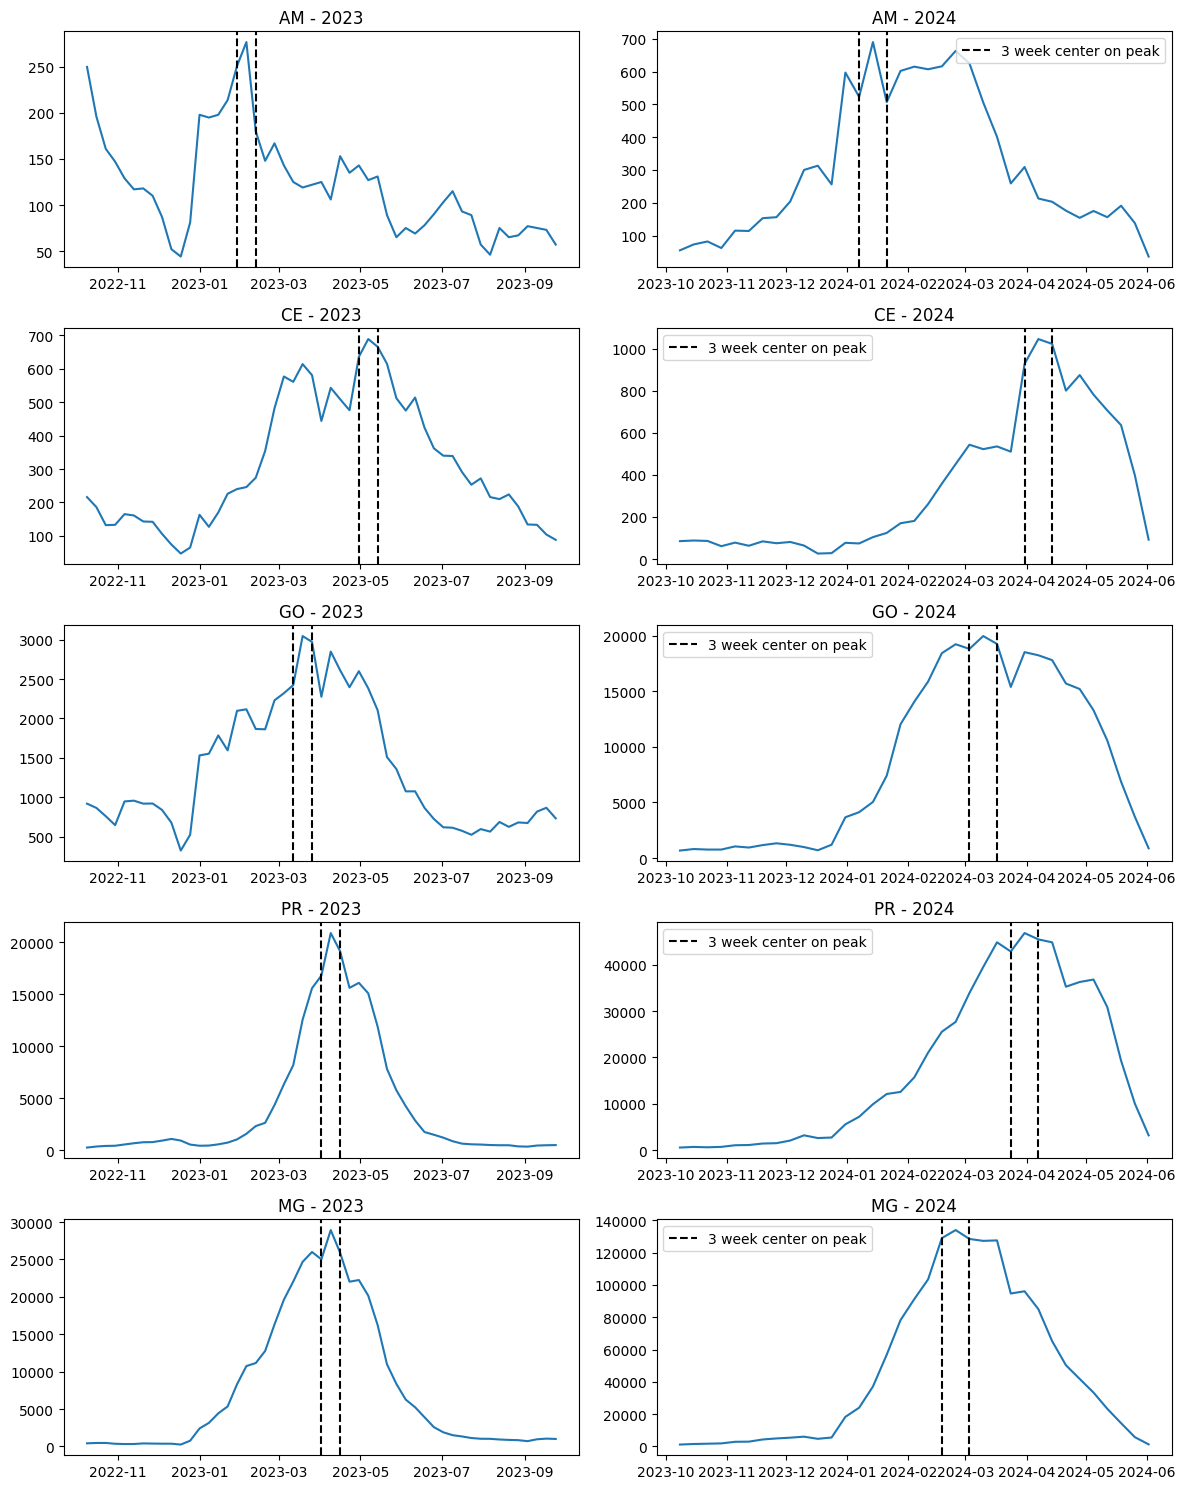

In [7]:

fig, ax = plt.subplots(5,2, figsize = (12, 15))

axs = ax.ravel()

i=0 
for state in ['AM', 'CE', 'GO', 'PR', 'MG']:
    
    df_23 = get_cases(data_23, state)
    
    axs[i].plot(df_23.dates, df_23.casos)

    axs[i].set_title(f'{state} - 2023')

    peak_date = pd.to_datetime(df_23.loc[df_23.casos == df_23['casos'].max()].dates.values[0])

    pd1 = peak_date - pd.Timedelta(weeks=1)

    pd2 = peak_date + pd.Timedelta(weeks=1)

    axs[i].axvline(pd1, color = 'black', ls = '--')

    axs[i].axvline(pd2, color = 'black', ls = '--')

    peak_dates[state][2023]['start_date'] = pd1
    peak_dates[state][2023]['end_date'] = pd2

    df_24 = get_cases(data_24, state)
    
    axs[i+1].plot(df_24.dates, df_24.casos)

    axs[i+1].set_title(f'{state} - 2024')

    peak_date = pd.to_datetime(df_24.loc[df_24.casos == df_24['casos'].max()].dates.values[0])

    pd1 = peak_date - pd.Timedelta(weeks=1)

    pd2 = peak_date + pd.Timedelta(weeks=1)

    peak_dates[state][2024]['start_date'] = pd1
    peak_dates[state][2024]['end_date'] = pd2

    axs[i+1].axvline(pd1, color = 'black', ls = '--')

    axs[i+1].axvline(pd2, color = 'black', ls = '--', label = '3 week center on peak')

    axs[i+1].legend()

    i = i+2

plt.tight_layout()

In [8]:
peak_dates

{'AM': {2023: {'start_date': Timestamp('2023-01-29 00:00:00'),
   'end_date': Timestamp('2023-02-12 00:00:00')},
  2024: {'start_date': Timestamp('2024-01-07 00:00:00'),
   'end_date': Timestamp('2024-01-21 00:00:00')}},
 'CE': {2023: {'start_date': Timestamp('2023-04-30 00:00:00'),
   'end_date': Timestamp('2023-05-14 00:00:00')},
  2024: {'start_date': Timestamp('2024-03-31 00:00:00'),
   'end_date': Timestamp('2024-04-14 00:00:00')}},
 'GO': {2023: {'start_date': Timestamp('2023-03-12 00:00:00'),
   'end_date': Timestamp('2023-03-26 00:00:00')},
  2024: {'start_date': Timestamp('2024-03-03 00:00:00'),
   'end_date': Timestamp('2024-03-17 00:00:00')}},
 'PR': {2023: {'start_date': Timestamp('2023-04-02 00:00:00'),
   'end_date': Timestamp('2023-04-16 00:00:00')},
  2024: {'start_date': Timestamp('2024-03-24 00:00:00'),
   'end_date': Timestamp('2024-04-07 00:00:00')}},
 'MG': {2023: {'start_date': Timestamp('2023-04-02 00:00:00'),
   'end_date': Timestamp('2023-04-16 00:00:00')},
  2

Teams and model_id na plataforma: 


| Team                     | Model id |
| ------------------------ | ------------- |
| D-fense                  | ------------  |
| Dobby Data               | 21            |
| GeoHealth                | 25,26         |
| Global Health Resilience | 22            |
| BNN                      | 30            |
| Ki-Dengu Peppa           | 27, 28        |
| DS_OKSTATE               | 29            |
 


The cell below fetch the predictions from the API and compute the scores for the 52 weeks interval saved on the `df_score_end_52` dataframe and for the 26 weeks interval saved on the `df_score_end_26` dataframe. 

In [9]:
%%time 
df_score_end_52  = pd.DataFrame()
df_score_end_26  = pd.DataFrame()

for model_id in [21, 22, 25,26, 27, 28, 29, 30]:

    list_of_preds = get_predictions(model_id = model_id)

    for idx in np.arange(0, len(list_of_preds)): 

        df = list_of_preds[idx].to_dataframe()
        state = df.adm_1.unique()[0]

        if state in ['AM', 'CE', 'GO', 'PR', 'MG']:
            preds_id = list_of_preds[idx].id
            df_true = get_cases(data, state)
    
            score = Scorer(df_true = df_true, ids = [preds_id], confidence_level=0.9)

            year = pd.to_datetime(df.dates).dt.year.max()

            score.set_date_range(start_date = Week(year-1, 41).startdate().strftime('%Y-%m-%d'),
                                 end_date= Week(year, 40).startdate().strftime('%Y-%m-%d'))
            

            year = pd.to_datetime(df.dates).dt.year.max()
            df_score_52 = score.summary
            df_score_52['state'] = state
            df_score_52['year'] = year
            if model_id == 26:
                df_score_52['model_id'] = 25
            else:
                df_score_52['model_id'] = model_id

            score.set_date_range(start_date = Week(year-1, 41).startdate().strftime('%Y-%m-%d'),
                                 end_date= Week(year, 14).startdate().strftime('%Y-%m-%d'))

            df_score_26 = score.summary
            df_score_26['state'] = state
            df_score_26['year'] = year
            
            if model_id == 26:
                df_score_26['model_id'] = 25
            else:
                df_score_26['model_id'] = model_id

            df_score_end_52 = pd.concat([df_score_end_52, df_score_52])
            df_score_end_26 = pd.concat([df_score_end_26, df_score_26])
            

CPU times: user 42.6 s, sys: 2.1 s, total: 44.7 s
Wall time: 2min 16s


Checking the shape od the data:

In [10]:
df_score_end_52.shape

(60, 8)

In [11]:
df_score_end_26.shape

(60, 8)

Checking for null values:

In [12]:
df_score_end_52.isnull().sum()

mae               0
mse               0
crps              0
log_score         0
interval_score    0
state             0
year              0
model_id          0
dtype: int64

In [13]:
df_score_end_26.isnull().sum()

mae               0
mse               0
crps              0
log_score         0
interval_score    0
state             0
year              0
model_id          0
dtype: int64

In [14]:
df_score_end_52.model_id.value_counts()

model_id
21    10
22    10
25    10
27    10
28    10
30    10
Name: count, dtype: int64

In [15]:
df_score_end_26.model_id.value_counts()

model_id
21    10
22    10
25    10
27    10
28    10
30    10
Name: count, dtype: int64

## Analysing the scores

Functions to rank the models:

In [16]:
def compute_the_rank_by_scores(df_52_, df_26_): 
    '''
    Rank the models by each of the scores S1,..., S6 proposed. 
    '''
    
    S1 = df_52_[['crps', 'model_id']].copy()
    S1['rank'] = df_52_['crps'].rank(method='dense', ascending=True)
    S1['score'] = 'S1'

    S2 = df_26_[['crps', 'model_id']].copy()
    S2['rank'] = df_26_['crps'].rank(method='dense', ascending=True)
    S2['score'] = 'S2'

    S3 = df_52_[['log_score', 'model_id']].copy()
    S3['rank'] = df_52_['log_score'].rank(method='dense', ascending=False)
    S3['score'] = 'S3'

    S4 = df_26_[['log_score', 'model_id']].copy()
    S4['rank'] = df_26_['log_score'].rank(method='dense', ascending=False)
    S4['score'] = 'S4'

    S5 = df_52_[['interval_score', 'model_id']].copy()
    S5['rank'] = df_52_['interval_score'].rank(method='dense', ascending=True)
    S5['score'] = 'S5'

    S6 = df_26_[['interval_score', 'model_id']].copy()
    S6['rank'] = df_26_['interval_score'].rank(method='dense', ascending=True)
    S6['score'] = 'S6'

    S = pd.concat([S1, S2, S3, S4, S5, S6]).reset_index(drop = True)

    S = pd.pivot_table(S, values = 'rank', index='model_id',
                      columns = ['score'])

    S.columns = 'rank_' + S.columns 

    return S

def compute_the_final_rank(S):
    '''
    Get the final rank of the models based on the output of the compute_the_rank_by_scores function. 
    '''
    v_r_end = []
    for model_id in S.index: 
    
        rank_final = ((1/S.loc[model_id]['rank_S1']) +
                     (1/S.loc[model_id]['rank_S2']) +
                     (1/S.loc[model_id]['rank_S3']) + 
                     (1/S.loc[model_id]['rank_S4']) + 
                     (1/S.loc[model_id]['rank_S5']) + 
                     (1/S.loc[model_id]['rank_S6']))
    
        v_r_end.append(rank_final)
    
    df_rank = pd.DataFrame()
    
    df_rank['model_id'] = S.index
    df_rank['rank_values'] = v_r_end

    df_rank['rank'] = df_rank['rank_values'].rank(method='dense', ascending=False) 
    df_rank['state'] = state
    df_rank['year'] = year

    df_rank = df_rank.set_index('model_id')

    df_rank = df_rank.rename(columns = {'rank':'rank_final'})

    df_rank = S.merge(df_rank[['rank_final', 'state', 'year']], left_index = True, right_index = True)

    for c in ['rank_S1', 'rank_S2', 'rank_S3', 
                                         'rank_S4', 'rank_S5', 'rank_S6', 'rank_final']:

        df_rank[c] = df_rank[c].astype(int)

    return df_rank.sort_values(by ='rank_final')

Get the final rank for each state and year and create a figure of the table colored according to the rank value: 

In [17]:
import seaborn as sns
import dataframe_image as dfi
from itertools import product 

In [18]:
df_52 = df_score_end_52
df_26 = df_score_end_26

In [22]:
%%time 
for state, year in product(['AM','CE','GO','PR','MG'], [2023, 2024]):
    df_52_ = df_52.loc[(df_52.state == state) & (df_52.year == year)]
    df_26_ = df_26.loc[(df_26.state == state) & (df_26.year == year)]

    S_end = compute_the_rank_by_scores(df_52_, df_26_)

    R_end = compute_the_final_rank(S_end)
    R_end.to_csv(f'tables/ranking_{state}_{year}.csv')

    R_end = R_end.style.background_gradient(subset= ['rank_S1', 'rank_S2', 'rank_S3', 
                                             'rank_S4', 'rank_S5', 'rank_S6', 'rank_final'], cmap=cm)
    
    
    dfi.export(R_end, f'./figures/ranking_{state}_{year}.png')

CPU times: user 514 ms, sys: 141 ms, total: 655 ms
Wall time: 4.31 s


Get the final rank for each state based on the rank of each year:

In [25]:
for state in ['AM', 'CE', 'GO', 'PR', 'MG']:
    df_r_2023 = pd.read_csv(f'tables/ranking_{state}_2023.csv', index_col = 'model_id')
    
    df_r_2024 = pd.read_csv(f'tables/ranking_{state}_2024.csv', index_col = 'model_id')
    
    v_r_end = []
    for model_id in df_r_2023.index: 
        
            rank_final = ((1/df_r_2023.loc[model_id]['rank_final']) +
                         (1/df_r_2024.loc[model_id]['rank_final']))
        
            v_r_end.append(rank_final)
        
    df_rank = pd.DataFrame()
        
    df_rank['model_id'] = df_r_2023.index
    df_rank['rank_values'] = v_r_end
    
    df_rank['rank'] = df_rank['rank_values'].rank(method='dense', ascending=False) 
    df_rank['state'] = state
   
    df_rank.to_csv(f'tables/ranking_{state}.csv', index = False)

Get the global rank based on the rank of each mandatory state: 

In [27]:
list_of_dfs = [] 

for state in ['AM', 'CE', 'GO', 'PR', 'MG']: 

    df_rank_ = pd.read_csv(f'tables/ranking_{state}.csv', index_col = 'model_id', usecols = ['model_id', 'rank'])
    df_rank_ = df_rank_.rename(columns = {'rank': f'rank_{state}'} )

    list_of_dfs.append(df_rank_)
    
df_rank_states = pd.concat(list_of_dfs,axis =1)

df_rank_states    

,rank_AM,rank_CE,rank_GO,rank_PR,rank_MG
model_id,,,,,
30,1.0,1.0,2.0,1.0,2.0
21,2.0,2.0,3.0,2.0,3.0
22,1.0,4.0,1.0,1.0,4.0
25,2.0,3.0,4.0,2.0,1.0
27,3.0,6.0,6.0,4.0,6.0
28,3.0,5.0,5.0,3.0,5.0


In [31]:
v_r_end = []

for model_id in df_rank_states.index: 

    rank_final = (
                         (1/df_rank_states.loc[model_id]['rank_AM']) +
                         (1/df_rank_states.loc[model_id]['rank_CE']) + 
                         (1/df_rank_states.loc[model_id]['rank_GO']) + 
                         (1/df_rank_states.loc[model_id]['rank_MG']) + 
                         (1/df_rank_states.loc[model_id]['rank_PR']))
    v_r_end.append(rank_final)
    
df_rank = pd.DataFrame()
    
df_rank['model_id'] = df_rank_states.index
df_rank['rank_values'] = v_r_end
    
df_rank['rank'] = df_rank['rank_values'].rank(method='dense', ascending=False) 

df_rank.set_index('model_id',inplace = True)

df_rank = df_rank.rename(columns = {'rank': 'rank_global'})

df_rank = df_rank_states.merge(df_rank['rank_global'], left_index = True, right_index = True)

df_rank = df_rank.sort_values(by = 'rank_global')

df_rank = df_rank.astype(int)

df_rank.head(6)

,rank_AM,rank_CE,rank_GO,rank_PR,rank_MG,rank_global
model_id,,,,,,
30,1,1,2,1,2,1
22,1,4,1,1,4,2
25,2,3,4,2,1,3
21,2,2,3,2,3,4
28,3,5,5,3,5,5
27,3,6,6,4,6,6


Coloring the dataset: 

In [32]:
df_rank = df_rank.style.background_gradient(cmap=cm)

dfi.export(df_rank, f'./figures/ranking_global.png')